<div style="text-align: center; font-size: 36px; font-weight: bold; color: #2E86C1;">Deep Learning - Final Assignment</div>
<div style="text-align: center; font-size: 20px; color: #555;">Group 007 | Eran Tascesme - 205708720 | Yael Peleg 318659810 | Ido Rappaport 322891623  </div>

<div style="font-family: Times; text-align: center; font-size: 40px; font-weight: bold; background-color: #dfc8c6; color: #429eda;"><b>Part A</b></div>
<div style="text-align: center; background-color: #dfc8c6; font-size: 30px; color: #429eda;">Classification</div>

<div style="font-family: Times; font-size: 16px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🔽<b> Import Libraries</b></div>
</div>

In [1]:
import torch
import os
import time
import wandb
import optuna
import sklearn
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from functools import partial
from torch import nn, optim
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split, Dataset
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold

import warnings
warnings.filterwarnings("ignore")

C:\Users\erantascesme\.conda\envs\DeepLearning_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div style="font-family: Times; font-size: 16px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🖥<b> Define GPU</b></div>
</div>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🌀<b> Trasformation and Augmentation</b></div>
We created a dictionary that contains image preparation for use in the model. We also created a dictionary of augmentation methods for Van Gogh images to overcome the octave ratio
</div>


In [3]:
transforms_dict = {
    "vgg": [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
    ], 
    "alexnet": [
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    
}

augmentations = {
        "0": transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
        "1": transforms.RandomHorizontalFlip(p=1.0),
        "2": transforms.RandomVerticalFlip(p=1.0),
        "3": transforms.RandAugment(num_ops=1, magnitude=5),
        "4": transforms.RandAugment(num_ops=1, magnitude=9),
        "5": transforms.ColorJitter(brightness=0.5),
        "6": transforms.ColorJitter(contrast=0.5),
        "7": transforms.ColorJitter(saturation=0.5),
        "8": transforms.ColorJitter(hue=0.3),
        "9": transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        "10": transforms.RandomAffine(degrees=30, translate=(0.2, 0.05)),
        "11": transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
        "12": transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.1, 2.0)),
        "13": transforms.RandomPerspective(distortion_scale=0.5, p=1.0),
        "14": transforms.RandomErasing(p=1.0),
        "15": transforms.RandomRotation(degrees=30),
        "16": transforms.RandomRotation(degrees=60),
        "17": transforms.RandomRotation(degrees=90),
        "18": transforms.RandomRotation(degrees=120),
        "19": transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET)
}

<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🎨<b> ArtDataset Object</b></div>
We created a ArtDataset class - that load the images displayed in csv and, if necessary, we create augmentations through it</div>

In [4]:
class ArtDataset(Dataset):
    def __init__(self, csv_data, image_folder, transform=None):
        self.data = csv_data
        self.image_folder = image_folder
        self.transform = transform
        
        self.data["augmentation"] = 0

    def apply_augmentation(self):
        van_gogh_count = self.data[self.data["label"] == 1].shape[0]
        total_count = self.data.shape[0]
        
        if van_gogh_count == 0:
            return
        
        delta = total_count - van_gogh_count
        num_of_augmentation_needed = delta // van_gogh_count
        van_gogh_rows = self.data[self.data["label"] == 1]

        augmentation_rows = pd.concat(
            [van_gogh_rows.assign(augmentation=i) for i in range(1, num_of_augmentation_needed)])

        self.data = pd.concat([self.data, augmentation_rows], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_folder, row['filename'])
        
        image = Image.open(f"{img_path}.jpg").convert('RGB')  # Convert to RGB PIL Image
        
        aug_type = row["augmentation"]
        if aug_type == 0:
            transform = transforms.Compose(transforms_dict[self.transform])
            image = transform(image)
        else:
            aug_type = str(aug_type % 20)
            resize = transforms_dict[self.transform][0]
            augment = augmentations[aug_type]
            totensor = transforms_dict[self.transform][1]
            normalize =transforms_dict[self.transform][2]
            
            pipeline = [resize, augment, totensor, normalize]
            
            transform = transforms.Compose(pipeline)
            
            image = transform(image)
            
                
        
        label = row['label']
        return image, label


# Paths
csv_file = r"C:\Users\erantascesme\DeepLearning\DL\classes.csv"  
image_folder = r"D:\Users\erantascesme\Desktop\Post_Impressionism"

<div style="font-family: Times; font-size: 16px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🛑<b> Early Stop</b></div>
</div>

In [5]:
def early_stop_check(patience, best_val_loss, best_val_loss_epoch, current_val_loss, current_val_loss_epoch):
    early_stop_flag = False  # Initialize flag to be False
    if current_val_loss < best_val_loss:
        # Update the parameters holding the best validation loss details
        best_val_loss = current_val_loss
        best_val_loss_epoch = current_val_loss_epoch
    else:
        # Check if more than acceptable epochs have passed without improvement
        if current_val_loss_epoch - best_val_loss_epoch > patience:
            early_stop_flag = True  # Change flag
    return best_val_loss, best_val_loss_epoch, early_stop_flag

<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 📡<b> Training Function</b></div>
During each batch run, we recorded the following evaluation metrics: accuracy, loss, F1-score, AUC-ROC, and the confusion matrix.
At the end of each epoch, we computed and saved the average values of these metrics.
Additionally, we stored the best-performing model across all epochs..</div>

In [6]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience, trial, fold_num, model_type):
    
    best_val_loss = float('inf') 
    best_val_loss_epoch = 0  
    early_stop_flag = False
    best_model_state = None  
    best_model_stats = None
    fold_list = []  # save the stats of all ephocs of each fold. (4 folds)

    for epoch in range(1, epochs + 1):
        print(f"epoch: {epoch}")
        
        model.train()
        
        train_loss = 0.0 
        total_train_samples = 0
        correct_train_predictions = 0 

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 
            
            outputs = model(inputs) 
            
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step() 

            # Accumulate training loss
            train_loss += loss.item() * inputs.size(0)
            total_train_samples += inputs.size(0)

            # Calculate correct predictions for training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()

            probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy()
            

        # Calculate average training loss and accuracy
        train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        # Validation loop
        model.eval()  
        
        val_loss = 0.0 
        total_val_samples = 0 
        correct_val_predictions = 0 
        
        total_val_f1_score = 0
        total_val_auc_roc = 0
        tn, fp, fn, tp = 0, 0, 0, 0     # for the confusion matrix
        
        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in val_loader: # iterate on the val_loader's batches
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)

                # Calculate correct predictions for validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val_predictions += (predicted == labels).sum().item()

                probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy()

                total_val_f1_score += f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted') * inputs.size(0)
                total_val_auc_roc += roc_auc_score(labels.cpu().numpy(), probabilities) * inputs.size(0)

                predicted_labels = predicted.cpu().numpy()
                true_labels = labels.cpu().numpy() 
                
                # Compute confusion matrix
                cm = confusion_matrix(true_labels, predicted_labels).ravel()
                tn += cm[0]
                fp += cm[1]
                fn += cm[2]
                tp += cm[3]

        # Calculate average validation loss and accuracy
        val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples
        val_f1 = total_val_f1_score / total_val_samples
        val_auc_roc = total_val_auc_roc / total_val_samples
        
        # Check for early stopping
        best_val_loss, best_val_loss_epoch, early_stop_flag = early_stop_check(patience, best_val_loss, best_val_loss_epoch, val_loss, epoch)

        # Save the best model under the best_model_state parameter
        if val_loss <= best_val_loss:
            best_model_state = model.state_dict()
            best_model_stats = [train_loss, train_accuracy, val_loss, val_accuracy, val_f1, val_auc_roc, tn, fp, fn, tp]

        fold_list.append([epoch, train_loss, train_accuracy, val_loss, val_accuracy, val_f1, val_auc_roc])

        if early_stop_flag:
            break

    # Save the best model as a .pt file
    if best_model_state is not None: 
        save_dir = r"D:\Users\erantascesme\models"
        model_path = os.path.join(save_dir, f"best_model_trial_{trial.number}_fold_{fold_num}_model_{model_type}_val_loss_{best_val_loss}.pt")
        torch.save(best_model_state, model_path)

    return best_val_loss, fold_list, model_path, best_model_stats

<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🧮<b> Objective Function</b></div>
The function is generic for any model you choose, necessary arguments are model, trasform func and layers to finetune.
We focused on optimizing the following hyperparameters: learning rate, weight decay, patience, and batch size.
Since this is a classification problem, we used cross-entropy loss as our objective function.

For fine-tuning, we selected the layers responsible for style transfer, based on insights from the article we studied.
The hyperparameter values were chosen by analyzing their impact on the loss function.</br>
Because we used kfold, we had to average values for each constraint and upload them to WANDB.</div>

In [7]:
# Optuna objective function
def objective(trial, model_name, transform, layers_to_unfreeze, model_pre):
    # Hyperparameter suggestions
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3) 
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-4)
    patience = trial.suggest_int("patience", 3, 10) 
    batch_size = trial.suggest_int("batch_size", 64, 128, step=16)

    criterion = nn.CrossEntropyLoss() # Classification.

    # Initialize Weights & Biases - the values in the config are the properties of each trial.
    wandb.init(project="Group07_project",
               config={
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "patience": patience,
        "batch_size": batch_size,
    },
    name=f"{model_name} - trial_{trial.number}")
    
    print(f"{model_name} - trail: {trial.number}")

    # Train the model and get the best validation loss
    data = pd.read_csv(csv_file)
    data['label'] = data['artist'].apply(lambda x: 1 if x.lower() == 'vincent van gogh' else 0)   # preparing the label as Binary, 1 is van gogh
    
    n_splits = 4
    avg_val_loss = 0   # avg val loss of all the folds
    list_of_folds = []  # the stats of all the folds

    # creating folds
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(kf.split(data, data['label'])):
        print(f"fold number: {fold}")
        
        dataset_train = ArtDataset(csv_data=data.iloc[train_idx], image_folder=image_folder, transform=transform)       
        dataset_val= ArtDataset(csv_data=data.iloc[val_idx], image_folder=image_folder, transform=transform)
        dataset_train.apply_augmentation   # apply augmentation only on training data

        train_subset = Subset(dataset_train, list(range(len(dataset_train))))
        val_subset = Subset(dataset_val, list(range(len(dataset_val))))

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Load the pre-trained model
        model = model_pre
        model = model.to(device)

        # Freeze layers
        for param in model.features.parameters():
            param.requires_grad = False
            
        # Unfreeze
        for layer_idx in layers_to_unfreeze.keys():
            layer = model.features[int(layer_idx)]
            for param in layer.parameters():
                param.requires_grad = True

        # Modify the classifier to fit our problem (2 classes)
        model.classifier[6] = nn.Linear(4096, 2) 
        model.classifier[6] = model.classifier[6].to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
        folder_best_val_loss, stats, model_path, best_model_stats = train_model_with_hyperparams(model, train_loader, val_loader, optimizer,
                                                                                                 criterion, epochs=70,patience=patience, trial=trial,
                                                                                                 fold_num=fold, model_type=transform)
        
        avg_val_loss = (1/n_splits)*folder_best_val_loss
        list_of_folds.append(stats)

        # save the best_model_stats of the trail/fold/model
        stats_file = model_path.replace(".pt", ".txt")
        with open(stats_file, "w") as f:
            f.write(", ".join(map(str, best_model_stats)))

    # WandB part (calculate the average values of the folds per epoch)
    results = {}
    for fold in list_of_folds:
        for epoch, train_loss, train_accuracy, val_loss, val_accuracy, val_f1, val_auc_roc in fold:
            if epoch not in results:
                results[epoch] = {
                    "train_loss": [],
                    "train_acc": [],
                    "val_loss": [],
                    "val_acc": [],
                    "val_f1": [],
                    "val_auc_roc": []
                }
            results[epoch]["train_loss"].append(train_loss)
            results[epoch]["train_acc"].append(train_accuracy)
            results[epoch]["val_loss"].append(val_loss)
            results[epoch]["val_acc"].append(val_accuracy)
            results[epoch]["val_f1"].append(val_f1)
            results[epoch]["val_auc_roc"].append(val_auc_roc)
    avg_results = []
    for epoch in sorted(results.keys()):
        avg_train_loss = np.mean(results[epoch]["train_loss"])
        avg_train_acc = np.mean(results[epoch]["train_acc"])
        avg_val_loss = np.mean(results[epoch]["val_loss"])
        avg_val_acc = np.mean(results[epoch]["val_acc"])
        avg_val_f1 = np.mean(results[epoch]["val_f1"])
        avg_val_auc_roc = np.mean(results[epoch]["val_auc_roc"])
        avg_results.append([
            epoch,
            avg_train_loss,
            avg_train_acc,
            avg_val_loss,
            avg_val_acc,
            avg_val_f1,
            avg_val_auc_roc
        ])
    for r in avg_results:
        wandb.log({ 
            "Epoch": r[0],
            "Train Loss": r[1],
            "Train Accuracy": r[2],
            "Validation Loss": r[3],
            "Validation Accuracy": r[4],
            "Validation F1": r[5],
            "Validation AUC_ROC": r[6]
        })
    
    wandb.finish()

    # Return best validation loss as the objective to minimize
    return avg_val_loss

<div style="font-family: Times; text-align: center; font-size: 25px; font-weight: bold; color: #429eda;"><b>VGG19 </b></div><div style="text-align: center; font-size: 20px; color: #555;">Finetunning section</div>

<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> ⚖️<b> Optuna Study for VGG</b></div>
</div>

In [8]:
layers_to_unfreeze = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
model_pre = models.vgg19(pretrained=True)

vgg_study = optuna.create_study(direction="minimize")
vgg_study.optimize(partial(objective, model_name="VGG19", transform="vgg", layers_to_unfreeze=layers_to_unfreeze, model_pre=model_pre),
               n_trials=15)

[I 2025-03-30 11:52:24,069] A new study created in memory with name: no-name-2032e20a-3aab-404e-ab58-8c5de660243e
wandb: Currently logged in as: erantascesme (erantascesme-tau). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


VGG19 - trail: 0
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14


Epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
Train Accuracy,▁▅▇▆▆▇▇▇▇▇██▇██████
Train Loss,█▄▃▃▃▂▂▂▂▂▁▁▂▁▁▂▁▁▁
Validation AUC_ROC,▄▇█▇█▇█████▇▇▇▅▅▂▃▁
Validation Accuracy,▆▇█▇█▇█████▇█▇▆▆▃▅▁
Validation F1,▆▇█▇▇▇▇████▆▇▇▆▅▃▄▁
Validation Loss,▂▁▁▂▁▁▂▁▂▂▂▄▂▃▆▄▆▇█
Epoch,19
Train Accuracy,0.994
Train Loss,0.01918
Validation AUC_ROC,0.97098


[I 2025-03-30 18:01:31,805] Trial 0 finished with value: 0.4089542420019638 and parameters: {'learning_rate': 0.00033227349835532197, 'weight_decay': 7.302955291468525e-05, 'patience': 10, 'batch_size': 96}. Best is trial 0 with value: 0.4089542420019638.


VGG19 - trail: 1
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁██▇█▇██████████████
Train Loss,█▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,█████▁▁▁████████████
Validation Accuracy,▅▇▁▇█▇▇▇▇███████████
Validation F1,▅▇▁▇█▇▇▇▇███████████
Validation Loss,▄▂█▂▁▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁
Epoch,20
Train Accuracy,1
Train Loss,1e-05
Validation AUC_ROC,1


[I 2025-03-30 22:21:49,087] Trial 1 finished with value: 0.0001517842395672415 and parameters: {'learning_rate': 0.00011930766572588935, 'weight_decay': 9.651732055092201e-05, 'patience': 6, 'batch_size': 64}. Best is trial 1 with value: 0.0001517842395672415.


VGG19 - trail: 2
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


Epoch,▁▂▃▄▅▅▆▇█
Train Accuracy,▁████████
Train Loss,█▁▁▂▂▁▁▁▁
Validation AUC_ROC,███▁█████
Validation Accuracy,██▄▆▁▇███
Validation F1,██▅▆▁▇███
Validation Loss,▁▁▃▂█▂▁▁▁
Epoch,9
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-03-31 01:22:48,730] Trial 2 finished with value: 8.11634116612052e-06 and parameters: {'learning_rate': 9.33583734150279e-05, 'weight_decay': 6.767364976618553e-05, 'patience': 5, 'batch_size': 96}. Best is trial 2 with value: 8.11634116612052e-06.


VGG19 - trail: 3
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Accuracy,▁███████████████████████████████████████
Train Loss,█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▇█▁▇▇▅▅▇▆███████████████████████████████
Validation F1,▇█▁▇▇▅▅▇▆███████████████████████████████
Validation Loss,▃▁█▄▅▅▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,49
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-03-31 10:54:57,089] Trial 3 finished with value: 5.486866022370345e-07 and parameters: {'learning_rate': 9.061120750704501e-05, 'weight_decay': 1.2085430767256744e-06, 'patience': 7, 'batch_size': 96}. Best is trial 3 with value: 5.486866022370345e-07.


VGG19 - trail: 4
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13


Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,▁▆▇▇███████████████████████████
Train Loss,█▆▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▃▁██▇██████████████████████████
Validation Accuracy,▃▂▁▆▆▇▆▇█████▇▇▇▇▇█████████████
Validation F1,▄▂▁▆▇▇▆▇█████▇▇▇▇▇█████████████
Validation Loss,▇██▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,31
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-03-31 14:09:39,866] Trial 4 finished with value: 3.4281120392919917e-07 and parameters: {'learning_rate': 0.00020095491825242236, 'weight_decay': 5.094931646266079e-06, 'patience': 6, 'batch_size': 112}. Best is trial 4 with value: 3.4281120392919917e-07.


VGG19 - trail: 5
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
Train Accuracy,▁███████████████████████████████████████
Train Loss,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation F1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,59
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-03-31 20:57:27,312] Trial 5 finished with value: 4.2238773921145936e-07 and parameters: {'learning_rate': 2.3772902987826784e-05, 'weight_decay': 4.701239814927945e-06, 'patience': 3, 'batch_size': 64}. Best is trial 4 with value: 3.4281120392919917e-07.


VGG19 - trail: 6
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
fold number: 3


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Accuracy,▁███████████████████████████████████████
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation F1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▃▃▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,47
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-04-01 04:22:49,123] Trial 6 finished with value: 2.827677052716728e-06 and parameters: {'learning_rate': 6.0814653629076175e-05, 'weight_decay': 5.5104264300205034e-06, 'patience': 9, 'batch_size': 128}. Best is trial 4 with value: 3.4281120392919917e-07.


VGG19 - trail: 7
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Train Accuracy,▁███████████████████████████████████████
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation F1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▆█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,41
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-04-01 10:02:41,548] Trial 7 finished with value: 4.96830565632006e-06 and parameters: {'learning_rate': 5.469227046988756e-05, 'weight_decay': 9.123463922341824e-06, 'patience': 7, 'batch_size': 112}. Best is trial 4 with value: 3.4281120392919917e-07.


VGG19 - trail: 8
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13


Epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Train Accuracy,▁▆▇▆▆▇▇▇▆▇▇▇█▇███████████
Train Loss,█▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▃▄▁▆▇▁▅▃▆▅▁▄▅▁▃▇▇████████
Validation Accuracy,▃▄▃▅▁▄▆▁▆▅▄▅▅▄▄▇▆████████
Validation F1,▄▄▃▅▁▄▆▁▆▅▄▅▅▄▄▇▆████████
Validation Loss,▄▄▆▃█▄▃▇▃▃▅▄▃▆▄▂▃▁▁▁▁▁▁▁▁
Epoch,25
Train Accuracy,1
Train Loss,1e-05
Validation AUC_ROC,1


[I 2025-04-01 13:53:06,401] Trial 8 finished with value: 0.00043288994163864406 and parameters: {'learning_rate': 0.0005032565185578855, 'weight_decay': 1.4637342391355974e-05, 'patience': 9, 'batch_size': 64}. Best is trial 4 with value: 3.4281120392919917e-07.


VGG19 - trail: 9
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15


Epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
Train Accuracy,▁████████████████████
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁████████████████████
Validation F1,▁████████████████████
Validation Loss,█▁▂▁▂▆▂▂▄▃▂▁▂▁▁▁▁▁▁▁▁
Epoch,21
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-04-01 18:39:42,414] Trial 9 finished with value: 5.546237127328536e-06 and parameters: {'learning_rate': 0.00013001538379250446, 'weight_decay': 2.2048699104907116e-05, 'patience': 10, 'batch_size': 128}. Best is trial 4 with value: 3.4281120392919917e-07.


VGG19 - trail: 10
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8


Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▇█▇██▇███▆
Train Loss,█▃▁▂▁▁▂▁▁▁▃
Validation AUC_ROC,▁▆▇▇█▇▇██▇▅
Validation Accuracy,▄▇▆▇▅▆▆█▄▁▅
Validation F1,▃▇▆▇▄▆▆█▄▁▅
Validation Loss,▇▁▄▁▇▄▃▃▅█▃
Epoch,11
Train Accuracy,0.97773
Train Loss,0.0623
Validation AUC_ROC,0.9986


[I 2025-04-01 20:12:21,472] Trial 10 finished with value: 0.04427775852350261 and parameters: {'learning_rate': 0.0008412257794569159, 'weight_decay': 1.2236272504613026e-06, 'patience': 3, 'batch_size': 112}. Best is trial 4 with value: 3.4281120392919917e-07.


VGG19 - trail: 11
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33


Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Train Accuracy,▁▆▇█████████████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁█▁█████████████████████████████████████
Validation F1,▁▁██████████████████████████████████████
Validation Loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,64
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-04-02 05:39:22,453] Trial 11 finished with value: 3.7380695284040485e-06 and parameters: {'learning_rate': 1.154440026475331e-05, 'weight_decay': 3.384909213617921e-06, 'patience': 3, 'batch_size': 80}. Best is trial 4 with value: 3.4281120392919917e-07.


VGG19 - trail: 12
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoc

Epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
Train Accuracy,▁▆█▆▆███████████████████████████████████
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation F1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,70
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-04-02 16:13:59,978] Trial 12 finished with value: 2.2758575899399145e-07 and parameters: {'learning_rate': 1.8112785807764147e-05, 'weight_decay': 2.8494437361508917e-06, 'patience': 5, 'batch_size': 80}. Best is trial 12 with value: 2.2758575899399145e-07.


VGG19 - trail: 13
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23


Epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
Train Accuracy,▁▇██▆▇█████████████████
Train Loss,█▂▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,████▃▁█████████████████
Validation Accuracy,▇▇▆▅▁▅▇▇███████████████
Validation F1,▇▇▆▅▁▅▇▇███████████████
Validation Loss,▂▂▂▄█▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,23
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-04-02 18:42:12,525] Trial 13 finished with value: 4.469173812197011e-05 and parameters: {'learning_rate': 0.0002523750518067778, 'weight_decay': 2.6112559309140823e-06, 'patience': 5, 'batch_size': 80}. Best is trial 12 with value: 2.2758575899399145e-07.


VGG19 - trail: 14
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65


Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Accuracy,▁███████████████████████████████████████
Train Loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation F1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,70
Train Accuracy,1
Train Loss,0.0
Validation AUC_ROC,1


[I 2025-04-03 04:55:26,091] Trial 14 finished with value: 6.445899833677572e-07 and parameters: {'learning_rate': 2.6074307573050455e-05, 'weight_decay': 2.225095411633261e-06, 'patience': 5, 'batch_size': 112}. Best is trial 12 with value: 2.2758575899399145e-07.


<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🏆<b> Load the best VGG model</b></div>
</div>

In [9]:
vgg_best_model = models.vgg19(pretrained=True)
vgg_best_model.classifier[6] = nn.Linear(4096, 2)

# models_dir = r"D:\Users\erantascesme\models" 
models_dir = r"D:\Users\erantascesme\models" 

lowest_val_loss_vgg = float("inf")

for filename in os.listdir(models_dir):
    if filename.endswith(".pt") and "vgg" in filename:  # סינון רק למודלים של vgg
        file_path = os.path.join(models_dir, filename)
        model_data = torch.load(file_path)
        basename = filename.replace(".pt", "")
        parts = basename.split("_val_loss_")
        val_loss_str = parts[-1]
        val_loss = float(val_loss_str)
        
        if val_loss < lowest_val_loss_vgg:
            lowest_val_loss_vgg = val_loss
            best_model_path_vgg = file_path

vgg_best_model.load_state_dict(torch.load(best_model_path_vgg))

stats_file = best_model_path_vgg.replace(".pt", ".txt")
with open(stats_file, "r") as f:
    vgg_stats = [eval(line) for line in f][0]


<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 📊<b> Evaluation values and Confusion Matrix (for the best vgg model)</b></div>
</div>


    "train_loss": 0.013618653588769286,
    "train_accuracy": 0.9962878355225585,
    "val_loss": 1.9800112289473564e-08,
    "val_accuracy": 1.0,
    "val_f1": 1.0,
    "val_auc_roc": 1.0



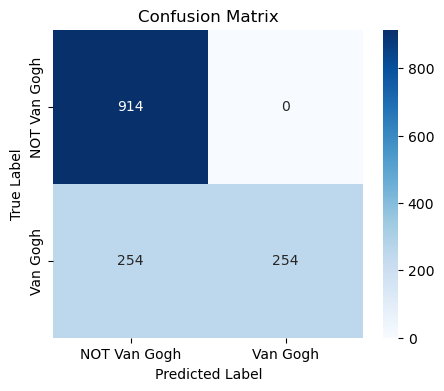

In [10]:
# show the stats and confusion matrix

print(f"""
    "train_loss": {vgg_stats[0]},
    "train_accuracy": {vgg_stats[1]},
    "val_loss": {vgg_stats[2]},
    "val_accuracy": {vgg_stats[3]},
    "val_f1": {vgg_stats[4]},
    "val_auc_roc": {vgg_stats[5]}
""")

tn, fp, fn, tp = vgg_stats[6], vgg_stats[8], vgg_stats[9], vgg_stats[9]

# Create the confusion matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NOT Van Gogh", "Van Gogh"], yticklabels=["NOT Van Gogh", "Van Gogh"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<div style="font-family: Times; text-align: center; font-size: 25px; font-weight: bold; color: #429eda;"><b>AlexNet </b></div><div style="text-align: center; font-size: 20px; color: #555;">Finetunning section</div>


<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> ⚖️<b> Optuna Study for AlexNet</b></div>
</div>

In [ ]:
layers_to_unfreeze = {'0': 'conv1_1', '3': 'conv2_1', '6': 'conv3_1', '8': 'conv4_1', '10': 'conv5_1'}
model_pre = models.alexnet(pretrained=True)

alexnet_study = optuna.create_study(direction="minimize")
alexnet_study.optimize(partial(objective, model_name="AlexNet", transform="alexnet", layers_to_unfreeze=layers_to_unfreeze, model_pre=model_pre),
               n_trials=15)

[I 2025-04-03 04:56:11,061] A new study created in memory with name: no-name-a5fa0716-82b5-4bd2-9e1f-a5c310f97a48


AlexNet - trail: 0
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
fold number: 3
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
Train Accuracy,▁▆▇▇████████████████████████████████▆███
Train Loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▁▁▁
Validation AUC_ROC,▁▂▃▃▃▃▃▃▃▃▇█████████████████████████████
Validation Accuracy,▇▇▇▇▇▇█████████████████████████████▁████
Validation F1,▆▇▇▇▇▇▇▇█▇███████████████████████████▁██
Validation Loss,▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
Epoch,68
Train Accuracy,1
Train Loss,0.00048
Validation AUC_ROC,1


[I 2025-04-03 10:54:26,036] Trial 0 finished with value: 0.0030118471311710356 and parameters: {'learning_rate': 3.415601050245724e-05, 'weight_decay': 4.321569955561597e-06, 'patience': 9, 'batch_size': 128}. Best is trial 0 with value: 0.0030118471311710356.


AlexNet - trail: 1
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
fold number: 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
fold number: 2
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epo

Epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
Train Accuracy,▁███████████████████████████████████████
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation AUC_ROC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆▆▆▆█▆▆▆███▆▆▆▆▆█▅█████████████████████
Validation F1,▁▁▁▁▁█▁▁█▁██▁▁▁█▁▁██████████████████████
Validation Loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,57
Train Accuracy,1
Train Loss,3e-05
Validation AUC_ROC,1


[I 2025-04-03 19:00:47,106] Trial 1 finished with value: 1.2465369797470535e-05 and parameters: {'learning_rate': 1.5217809699975698e-05, 'weight_decay': 1.0667034106173125e-05, 'patience': 8, 'batch_size': 112}. Best is trial 1 with value: 1.2465369797470535e-05.


AlexNet - trail: 2
fold number: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10


<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🏆<b> Load the best AlexNet model</b></div>
</div>

In [ ]:
alexnet_best_model = models.alexnet(pretrained=True)
alexnet_best_model.classifier[6] = nn.Linear(alexnet_best_model.classifier[6].in_features, 2)

models_dir = r"D:\Users\erantascesme\models"

lowest_val_loss_alexnet = float("inf")

for filename in os.listdir(models_dir):
    if filename.endswith(".pt") and "alexnet" in filename:  # סינון רק למודלים של alexnet
        file_path = os.path.join(models_dir, filename)
        model_data = torch.load(file_path)
        basename = filename.replace(".pt", "")
        parts = basename.split("_val_loss_")
        val_loss_str = parts[-1]
        val_loss = float(val_loss_str)
        
        if val_loss < lowest_val_loss_alexnet:
            lowest_val_loss_alexnet = val_loss
            best_model_path_alexnet = file_path

alexnet_best_model.load_state_dict(torch.load(best_model_path_alexnet))

stats_file = best_model_path_alexnet.replace(".pt", ".txt")
with open(stats_file, "r") as f:
    alexnet_stats = [eval(line) for line in f][0]

<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 📊<b> Evaluation values and Confusion Matrix (for the best alexnet model)</b></div>
</div>

In [ ]:
# show the stats and confusion matrix

print(f"""
    "train_loss": {alexnet_stats[0]},
    "train_accuracy": {alexnet_stats[1]},
    "val_loss": {alexnet_stats[2]},
    "val_accuracy": {alexnet_stats[3]},
    "val_f1": {alexnet_stats[4]},
    "val_auc_roc": {alexnet_stats[5]}
""")

tn, fp, fn, tp = alexnet_stats[6], alexnet_stats[8], alexnet_stats[9], alexnet_stats[9]

# Create the confusion matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NOT Van Gogh", "Van Gogh"], yticklabels=["NOT Van Gogh", "Van Gogh"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<div style="font-family: Times; text-align: center; font-size: 40px; font-weight: bold; background-color: #dfc8c6; color: #429eda;"><b>Part B</b></div>
<div style="text-align: center; background-color: #dfc8c6; font-size: 30px; color: #429eda;">Style Transfer</div>

<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🖌<b> Style Transfer Auxiliary Functions</b></div>
</div>

In [ ]:
def load_image(img_path, shape =(224,224), image=None):
    # Load the image
    image = Image.open(img_path).convert('RGB')

    in_transform = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
    # Discard the alpha channel
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image.to(device)


def get_features(image, model, layers=None):
    features= {}  # Dictionary to hold the features
    x = image
    for name, layer in model._modules.items():
        x = layer(x) # Forward pass
        if name in layers:
            features[layers[name]] = x  # Save the features
    return features

# Gram matrix
def gram_matrix(tensor):
    _, d, h, w= tensor.size()    # Get the dimensions
    tensor= tensor.view(d, h*w)
    gram= torch.mm(tensor, tensor.t())  # Matrix multiplication
    return gram


<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🎨<b> Style Transfer Function</b></div>
</div>

In [ ]:
def style_transfer(model, model_name, style_img_path, content_img_path, layers, style_weights, content_layer, num_steps=5000, style_weight=10000, content_weight=1):
    
    model = model.features
    model.to(device).eval()
    
    # Freeze the model parameters
    for param in model.parameters():
        param.requires_grad = False

    content = load_image(content_img_path).to(device)
    style = load_image(style_img_path).to(device)

    # Get the content and style features
    content_features = get_features(content, model, layers)
    style_features = get_features(style, model, layers)

    # Create a third "target" image and prep it for change
    target = content.clone().requires_grad_(True).to(device)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    optimizer = optim.Adam([target], lr=0.003)

    #style transfer loop
    for ii in range(1, num_steps+1):
        if ii % 1000 == 0:
            print(f"step: {ii}")
        # Get the features from the target image
        target_features = get_features(target, model, layers)
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
            _, d, h, w = target_feature.shape
            style_loss += layer_style_loss/(d*h*w)
        total_loss= content_weight*content_loss + style_weight*style_loss
        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        optimizer.step()
    return target


In [ ]:
main_file = r"C:\Users\erantascesme\DeepLearning\DL"
content_file = r"C:\Users\erantascesme\DeepLearning\DL\content_images"
style_file = r"C:\Users\erantascesme\DeepLearning\DL\style_images"

<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🎭<b> make_transfer Function</b></div>
    make_transfer is a generic function that make style transfer for each pair images (style, content) by model you choose
</div>

In [ ]:
def make_transfer(model_to_copy, model_name, layers, style_weights, content_layer):
    for content_img in os.listdir(content_file):
        if content_img.endswith((".jpg", ".jpeg")):
            content_file_name = os.path.splitext(content_img)[0]
            content_img_path = os.path.join(content_file, content_img)
            for style_img in os.listdir(style_file):
                if style_img.endswith((".jpg", ".jpeg")):
                    style_img_path = os.path.join(style_file, style_img)
                    new_file_name = content_file_name + os.path.splitext(style_img)[0]
                    
                    final_image = style_transfer(model, model_name=model_name, style_img_path=style_img_path, content_img_path=content_img_path,
                                                layers=layers, style_weights=style_weights, content_layer=content_layer)
                    
                    final_image = final_image.detach().cpu().numpy()
                    
                    final_image = final_image.squeeze(0).transpose(1, 2, 0)
                    final_image = np.clip(final_image, 0, 1)
                        
                    plt.imshow(final_image)
                    plt.show()
    
                    final_image = (255 * (final_image - final_image.min()) / (final_image.max() - final_image.min())).astype(np.uint8)
                    if final_image.shape[-1] == 3:  # Check if it has color channels
                        final_image = final_image[..., ::-1]
                    
                    image = Image.fromarray(final_image)
                    
                    img_final_name = os.path.join(main_file, new_file_name + model_name + ".jpg")
                    image.save(img_final_name, 'JPEG')
                    

<div style="font-family: Times; text-align: center; font-size: 25px; font-weight: bold; color: #429eda;"><b>Transfer the images by 4 models</b></div>


In [ ]:
vgg_layers = { '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'
         }

vgg_style_weights = {   'conv1_1': 0.01,
                    'conv2_1': 0.01,
                    'conv3_1': 0.01,
                    'conv4_1': 0.001,
                     'conv5_1': 0.001
                }

vgg_content_layer = 'conv4_2'

In [ ]:
alexnet_layers = { '0': 'conv1_1',
        '3': 'conv2_1',
        '6': 'conv3_1',
        '8': 'conv4_1',
        '10': 'conv5_1'
     }

alexnet_style_weights = { 'conv1_1': 0.2,
                'conv2_1': 0.2,
                'conv3_1': 0.2,
                'conv5_1': 0.3
            }

alexnet_content_layer = 'conv4_1'

<div style="font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 15px;"> 🖼 <b>VGG pretrained <u>NOT</u> finetuned</b></div>
</div>

In [ ]:
vgg_pre_model = models.vgg19(pretrained=True)
model = vgg_pre_model
make_transfer(model, "vgg_pre", vgg_layers, vgg_style_weights, vgg_content_layer)

<div style="font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 15px;"> 🖼 <b>AlexNet pretrained <u>NOT</u> finetuned</b></div>
</div>

In [ ]:
alexnet_pre_model = models.alexnet(pretrained=True)
model = alexnet_pre_model
make_transfer(model, "alexnet_pre", alexnet_layers, alexnet_style_weights, alexnet_content_layer)

<div style="font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 15px;"> 🖼 <b>VGG finetuned</b></div>
</div>

In [ ]:
model = vgg_best_model
make_transfer(model, "vgg", vgg_layers, vgg_style_weights, vgg_content_layer)

<div style="font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 15px;"> 🖼 <b>AlexNet finetuned</b></div>
</div>

In [ ]:
model = alexnet_best_model
make_transfer(model, "alexnet", alexnet_layers, alexnet_style_weights, alexnet_content_layer)

<div style="font-family: Times; font-size: 18px; background-color: #EAF2F8; padding: 10px;">
<div style="color: #9238b7; font-size: 18px;"> 🎨<b> Evaluation</b></div>
in this part we will evaluate the styletransfer for each 4 models.</br>
for each model we use the 2 finetuned models and we try to classify the images.
</div>

In [ ]:
models_list = [(vgg_best_model, "vgg_classifier"), (alexnet_best_model, "alexnet_classifier") ]

In [ ]:
transforms_dict = {
        "vgg_classifier": [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
        ],
        "alexnet_classifier": [
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]   
}


In [ ]:
# Path to the folder with images
image_folder = r'C:\Users\erantascesme\DeepLearning\DL'

for model, model_name in models_list:
    model.eval()


# Get all image paths
image_paths = {
    "vgg_pre": [],
    "alexnet_pre": [],
    "vgg": [],
    "alexnet": []
}

for fname in os.listdir(image_folder):
    if fname.endswith('vgg_pre.jpg'):
        image_paths['vgg_pre'].append(image_folder + "\\" + fname)
    elif fname.endswith('alexnet_pre.jpg'):
        image_paths['alexnet_pre'].append(image_folder + "\\" + fname)
    elif fname.endswith('vgg.jpg'):
        image_paths['vgg'].append(image_folder + "\\" + fname)
    elif fname.endswith('alexnet.jpg'):
        image_paths['alexnet'].append(image_folder + "\\" + fname)
        

# Calculate average probability for label 1
avg_probs = {
    "vgg_pre": [],
    "alexnet_pre": [],
    "vgg": [],
    "alexnet": []
    
}

for model, model_name in models_list:
    # Define preprocessing (change size if needed)
    preprocess = transforms.Compose(transforms_dict[model_name])
    
    probs = {
        "vgg_pre": [],
        "alexnet_pre": [],
        "vgg": [],
        "alexnet": []
    
    }

    with torch.no_grad():
        for image_model, image_pathes in image_paths.items():
                for image_path in image_pathes:
                    # Load and preprocess image
                    image = Image.open(image_path).convert('RGB')
                    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
                    input_tensor = input_tensor.to(device)
                    # Forward pass
                    output = model(input_tensor)
        
                    # Get probabilities
                    prob = F.softmax(output, dim=1)[0, 1].item()  # Probability of label 1
                    probs[image_model].append(prob)
    
    # Calculate and store the average probability
    for key in probs.keys():
        avg_prob_add = sum(probs[key]) / len(probs[key])
        avg_probs[key].append((model_name, avg_prob_add))



In [ ]:
# Extract unique classifier names
classifiers = set()
for model_values in avg_probs.values():
    for classifier, _ in model_values:
        classifiers.add(classifier)

# Create a dictionary for DataFrame construction
data = {model: {classifier: None for classifier in classifiers} for model in avg_probs}

# Populate with probabilities
for model, values in avg_probs.items():
    for classifier, prob in values:
        data[model][classifier] = prob

# Convert to DataFrame
df = pd.DataFrame.from_dict(data, orient="index").T  # Transpose to get desired format

# Fill NaN with 0 (optional)
df = df.fillna(0)

display(df)